In [3]:
# Importamos el lemmatizar de NLTK, y creamos el objeto
import pandas as pd
from nltk.stem import WordNetLemmatizer
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk
wordnet_lemmatizer = WordNetLemmatizer()

# Importamos esta libreria que nos permite reemplzar caracteres
import re

dataset = pd.read_json('Sarcasm_Headlines_Dataset.json', lines= True)
dataset = dataset.drop(columns=["article_link"])
dataset.dropna(axis=0,inplace=True)

# Traemos nuevamente las stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [6]:
from nltk.corpus import wordnet

#recibe una palabra, y cogeré la primera letra, si es una j,n,v,r le pasaré que sea Adj,Nomb...

from nltk.corpus import wordnet

def lemmatizer_get_wordnet_pos_phrase(frase_tokens):

    new_tokens=[]
    pos_tokens=[]
    tag_dict = {"J": wordnet.ADJ, # Adjetivo
                "N": wordnet.NOUN, # Nombre
                "V": wordnet.VERB, # Verbo
                "R": wordnet.ADV} # adverbio
    
    tags=nltk.pos_tag(frase_tokens)
    for items in tags:
        pos = tag_dict.get(items[1][0], wordnet.NOUN)
        new_tokens.append(wordnet_lemmatizer.lemmatize(items[0],pos))
        pos_tokens.append(pos)

    return new_tokens, pos_tokens

In [7]:
def normalizar_lemmatizar(titular):
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    titular=re.sub("[^a-zA-Z]"," ",str(titular))
    # Pasamos todo a minúsculas
    titular=titular.lower()
     # Tokenizamos para separar las palabras
    titular=nltk.word_tokenize(titular)
     # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    titular, tipo_palabra = lemmatizer_get_wordnet_pos_phrase(titular)
    # Eliminamos las palabras de menos de 3 letras
    titular = [palabra for palabra in titular if len(palabra)>3]
    # Sacamos las Stopwords
    titular = [word for word in titular if word not in stopwords]
    ## Hasta aqui Normalizamos

    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
    return titular

In [8]:
dataset["titular_lemm"] = dataset.headline.apply(normalizar_lemmatizar)
dataset.tail()

,headline,is_sarcastic,titular_lemm
26704,american politics in moral free-fall,0,american politics moral free fall
26705,america's best 20 hikes,0,america best hike
26706,reparations and obama,0,reparation obama
26707,israeli ban targeting boycott supporters raise...,0,israeli target boycott supporter raise alarm a...
26708,gourmet gifts for the foodie 2014,0,gourmet gift foodie


We are going to build a new dataset called `dataset_lem` with only the columns `titular_lemm` and `is_sarcastic`.

In [9]:
dataset_lemm = dataset.drop(columns=["headline"])
dataset_lemm.head()

,is_sarcastic,titular_lemm
0,0,former versace store clerk secret black code m...
1,0,roseanne revival catch thorny political mood good
2,1,start fear series closest thing grandchild
3,1,boehner want wife listen come alternative debt...
4,0,rowling wish snape happy birthday magical



## Vectorise

So far, we have a group of words for each headline (bag of words), either *lemmatised* or *stemmatised*. Does this look like it will be useful for training models? The idea now is to represent this list of words as a vector. For this we are going to use Scikit-Learn's `CountVectorizer` function. This function allows us to represent each title by a vector with a `1` for the words it contains and a `0` for those it does not. Moreover, we are only going to work with the words that appear most often in the text, as those that appear only once or a few times will not provide us with information that can be generalised.


a. We prepare the bag of words to vector converter from sklearn. CountVectorizer has several functionalities that can be determined from parameters.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# Recibe un texto y lo transforma a una matriz de el estilo dataframe

# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000 # Coge las 1000 palabras con más frecuencia

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features) # stop_words="english" , ngram_range=(1, 2)



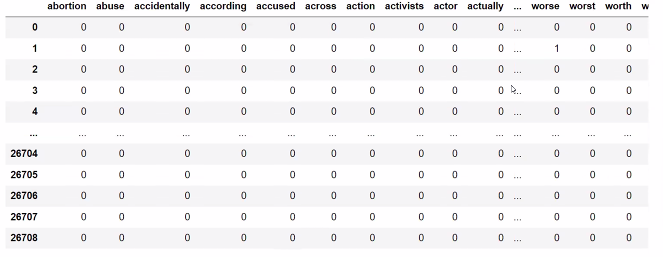

In [14]:
matriz_titulos = cou_vec.fit_transform(dataset_lemm['titular_lemm']) # le pasamos una columna de texto

# Tomamos las palabras
all_words = cou_vec.get_feature_names_out()

# Vizualizamos las 50 primeras palabras
print("50 palabras ordenadas alfabeticamente mas usadas: ",all_words[0:50])

50 palabras mas usadas:  ['abort' 'abus' 'accept' 'accident' 'account' 'accus' 'across' 'action'
 'activist' 'actor' 'actual' 'add' 'address' 'administr' 'admit' 'ador'
 'advic' 'age' 'agent' 'agre' 'aid' 'airlin' 'airport' 'album' 'alleg'
 'allow' 'almost' 'alreadi' 'alway' 'amaz' 'amazon' 'america' 'american'
 'amid' 'angel' 'anim' 'anniversari' 'announc' 'anoth' 'answer' 'anti'
 'anyon' 'anyth' 'apart' 'apolog' 'appar' 'appear' 'appl' 'approv' 'area']


## Modelling

Now we are ready to use all our modelling knowledge on this dataset. Please note that, depending on the number of features we have chosen, the models may take a while to train.

a. First, as always, we separate into test and train.

In [51]:
matriz_titulos.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [15]:
x = matriz_titulos.toarray()
y = dataset_lemm['is_sarcastic']

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

We also define a function that allows us to plot the results in a confusion matrix.

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    names=["No Sarcastico","Sarcastico"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

### Naive Bayes
Let's start with a Naive Bayes to have a reference benchmark for accuracy.

In [24]:
# SUele funcionar bien para estos problemas. 
# Estima la probabilidad teniendo una caracteristicas y las multiplica. Atribuye una probabilidad a cada caract.

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

nb.fit(xtrain,ytrain)
y_pred=nb.predict(xtest)

Let's see how the confusion matrix is plotted:

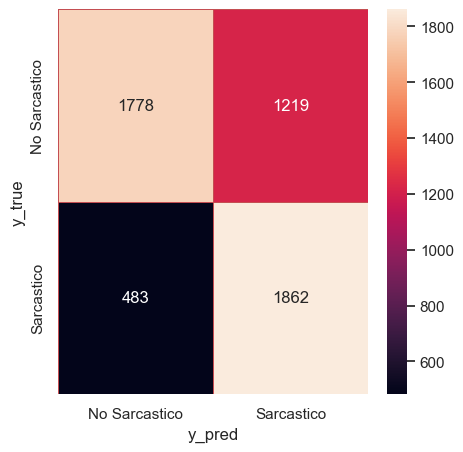

In [25]:
confusion(ytest,y_pred)

We can observe that when it predicts that the text is sarcastic, it is right in 1862 occasions but wrong in 1219, so we can affirm that this model would not be very useful due to its high error rate.


### Random Forest
Let's see how a random forest works to predict the sarcasm of a story based on its headline.

In [26]:
 from sklearn.ensemble import RandomForestClassifier

Confusion Matrix

In [29]:
rf=RandomForestClassifier()
rf.fit(xtrain,ytrain)
y_pred=rf.predict(xtest)

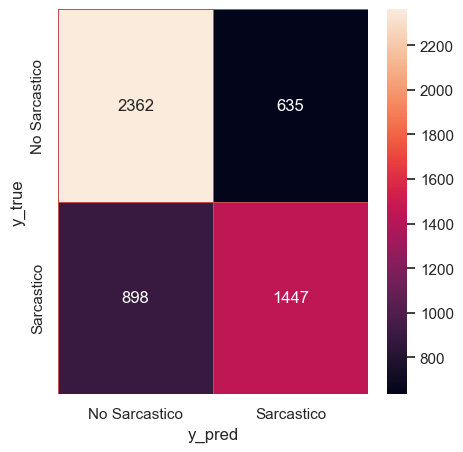

In [30]:
confusion(ytest,y_pred)

We see that it improves the prediction for sarcasm, but nevertheless, with the random forest algorithm, when it predicts that the text is not sarcastic it misses more than the Naive Bayes. Even so, we could consider that the model with Random Forest erroneously predicts a smaller amount than Naive Bayes. 

One of the great things about Random Forest was being able to ask it about the importance of the features it used to classify. Let's see in this case what are the words that mostly determine the sarcasm of a note for this classifier.

In [46]:
feature_importances = rf.feature_importances_

# Obtener las palabras correspondientes a las características
caracteristicas_importantes = list(zip(all_words, feature_importances))


In [48]:
caracteristicas_ordenadas = sorted(caracteristicas_importantes, key=lambda x: x[1], reverse=True)


In [57]:
for caracteristica, importancia in caracteristicas_ordenadas[:20]:
    print(f"{caracteristica}: {importancia * 100}")

area: 1.9999769342685614
trump: 1.737454768876252
report: 1.0103732868963373
nation: 0.9579595628547953
donald: 0.5985238561333581
local: 0.5356383529737274
studi: 0.5326198828570119
year: 0.5293387311980872
fuck: 0.5279474581050188
introduc: 0.5111697781136484
friend: 0.36171830404204125
woman: 0.3546139818741104
women: 0.3510425660547544
look: 0.34968845128768794
time: 0.3471605163763533
entir: 0.3409173913642863
like: 0.3398114408524375
cowork: 0.3169511880593264
shit: 0.3045834709660279
say: 0.30417543620896287


The 5 words that are most important in classifying whether the text is sarcastic or not are:
Area, trump,report,nation 

We could deduce that when these words are used, they tend to have an informative character where sarcasm does not usually come into play.

##  Try some suggestions

Let's try some suggestions to explore how:

1. Try Stemmizar instead of lemmantizar; 2.
1. Change the number of features you are taking. 1.
1. Include the 2-grams.


In [ ]:
#Prueba con Stemmizar en vez de lemmantizar

In [58]:
def normalizar_y_stemmizar(titular):
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    titular=re.sub("[^a-zA-Z]"," ",str(titular)) # he quitado todos los símbolos que no sean letras 
    # Pasamos todo a minúsculas
    titular=titular.lower() # minúsculas
    titular = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(titular) #tokenizado
    # Eliminamos las palabras de menos de 3 letras
    titular = [palabra for palabra in titular if len(palabra)>3]
    # Sacamos las Stopwords
    titular = [word for word in titular if word not in stopwords]
    ## Hasta aqui Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    titular=[stemmer.stem(palabra) for palabra in titular]
    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
    return titular

In [59]:
dataset.headline.apply(normalizar_y_stemmizar)  

0        former versac store clerk sue secret black cod...
1        roseann reviv catch thorni polit mood better wors
2                 start fear seri closest thing grandchild
3        boehner want wife listen come altern debt redu...
4                     rowl wish snape happi birthday magic
                               ...                        
26704                       american polit moral free fall
26705                                    america best hike
26706                                          repar obama
26707        isra target boycott support rais alarm abroad
26708                                   gourmet gift foodi
Name: headline, Length: 26709, dtype: object

In [61]:
dataset["titular_stem"] = dataset.headline.apply(normalizar_y_stemmizar) 
dataset.tail()

,headline,is_sarcastic,titular_stem
26704,american politics in moral free-fall,0,american polit moral free fall
26705,america's best 20 hikes,0,america best hike
26706,reparations and obama,0,repar obama
26707,israeli ban targeting boycott supporters raise...,0,isra target boycott support rais alarm abroad
26708,gourmet gifts for the foodie 2014,0,gourmet gift foodi


In [67]:
dataset_stem = dataset.drop(columns=["headline"])
dataset_stem.head()

,is_sarcastic,titular_stem
0,0,former versac store clerk sue secret black cod...
1,0,roseann reviv catch thorni polit mood better wors
2,1,start fear seri closest thing grandchild
3,1,boehner want wife listen come altern debt redu...
4,0,rowl wish snape happi birthday magic


In [70]:
from sklearn.feature_extraction.text import CountVectorizer

# Recibe un texto y lo transforma a una matriz de el estilo dataframe

max_features=2000 


cou_vec=CountVectorizer(max_features=max_features)

In [71]:
matriz_titulos = cou_vec.fit_transform(dataset_stem['titular_stem']) # le pasamos una columna de texto

# Tomamos las palabras
all_words = cou_vec.get_feature_names_out()

# Vizualizamos las 50 primeras palabras
print("50 palabras mas usadas ordenadas alfabéticamente: ",all_words[0:50])

50 palabras mas usadas:  ['abandon' 'abl' 'abort' 'absolut' 'abus' 'accept' 'access' 'accid'
 'accident' 'accord' 'account' 'accus' 'achiev' 'acquir' 'across' 'act'
 'action' 'activ' 'activist' 'actor' 'actress' 'actual' 'ad' 'adam' 'add'
 'addict' 'address' 'administr' 'admit' 'adopt' 'ador' 'adult' 'advanc'
 'advertis' 'advic' 'advis' 'advoc' 'affair' 'affect' 'afford' 'afghan'
 'afghanistan' 'africa' 'african' 'age' 'agent' 'agre' 'ahead' 'aid' 'aim']


In [72]:
x = matriz_titulos.toarray()
y = dataset_stem['is_sarcastic']

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [73]:
rf=RandomForestClassifier()
rf.fit(xtrain,ytrain)
y_pred=rf.predict(xtest)

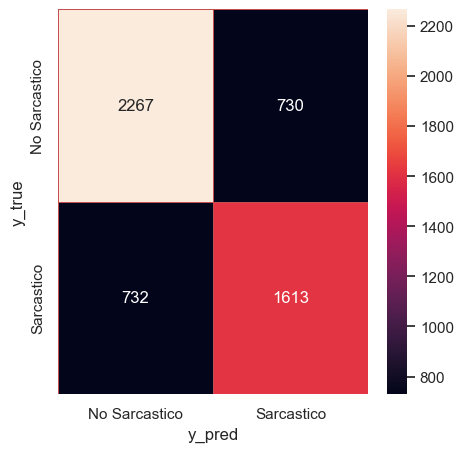

In [74]:
confusion(ytest,y_pred)

We can see that using 2000 words, and using stemmizer instead of lemmitizer, we got a bit better. Let's try modifying the count vectorizer now to take into account the bigrams, let's see the possible results of this.

In [75]:
from sklearn.feature_extraction.text import CountVectorizer


max_features=2000 # Coge las 1000 palabras con más frecuencia


cou_vec=CountVectorizer(max_features=max_features,ngram_range=(1, 2))

In [76]:
matriz_titulos = cou_vec.fit_transform(dataset_stem['titular_stem']) # le pasamos una columna de texto

# Tomamos las palabras
all_words = cou_vec.get_feature_names_out()

# Vizualizamos las 50 primeras palabras
print("50 palabras mas usadas ordenadas alfabéticamente: ",all_words[0:50])

50 palabras mas usadas:  ['abandon' 'abl' 'abort' 'absolut' 'abus' 'accept' 'access' 'accid'
 'accident' 'accord' 'account' 'accus' 'achiev' 'acquir' 'across' 'act'
 'action' 'activ' 'activist' 'actor' 'actress' 'actual' 'ad' 'adam' 'add'
 'addict' 'address' 'administr' 'admit' 'adopt' 'ador' 'adult' 'advanc'
 'advertis' 'advic' 'advis' 'advoc' 'affair' 'affect' 'afford' 'afghan'
 'afghanistan' 'africa' 'african' 'age' 'agent' 'agre' 'ahead' 'aid' 'aim']


In [77]:
x = matriz_titulos.toarray()
y = dataset_stem['is_sarcastic']

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [78]:
rf=RandomForestClassifier()
rf.fit(xtrain,ytrain)
y_pred=rf.predict(xtest)

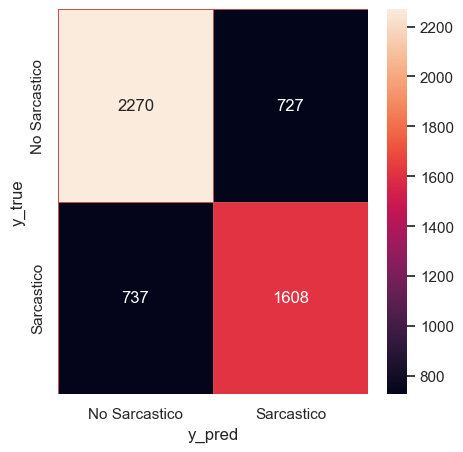

In [79]:
confusion(ytest,y_pred)

Conclusion:

The aim of this project is to determine whether a text is sarcastic or not. Since this term itself is very interpretable, we do not have a high expectation on its performance. 

In the first phase we normalised and lemmatised the text in order to vectorise it so that we could have it in numerical format for use with algorithms.

We see that the best performance is obtained with the Random Forest and we also saw that the words that are most important in the classification were: Area,tump,report,nation.

I decided to stem instead of lemmatise to see if there was a difference in the performance of the models.

What is the difference between stemming and lemmatising?

***Stemmatisation*** is the removal of suffixes from words to obtain their root or stem.
The result can be a root that is not necessarily a valid word in the language.
There may be some loss of accuracy, as the roots may not be real words and may be ambiguous.


***Lemmatisation*** involves reducing words to their base form or "lemma", taking into account their meaning in context.
The result is a valid word in the language that represents the same word in different grammatical forms.
It is a more precise process than stemmatisation, as it takes into account the context and grammar of the text.



We get better performance with lemmatisation although it is not a significant improvement. 
Within the lemmatisation, we did another one taking into account the bigrams, but the improvement was not substantial either.